In [1]:
from google.colab import drive
drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/Gesture_Recognition_Project/Project_data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Google_Colab_repo/
# !unzip Project_data.zip

/content/drive/MyDrive/Google_Colab_repo


# Gesture Recognition
- In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.</br>

# Functions, Flasses and Activities
---
>generator(): &nbsp;&nbsp;&nbsp;&nbsp; yield batch of images normalize</br>
get_step(): &nbsp;&nbsp;&nbsp;&nbsp; Create steps_per_epochs and validation_steps</br>
Gesture_Module: &nbsp;&nbsp;&nbsp;&nbsp; Contain all Models</br>
plot_accuracy(): &nbsp;&nbsp;&nbsp;&nbsp; Visualize values of Accuracy training</br>
plot_loss(): &nbsp;&nbsp;&nbsp;&nbsp; Visualize values of Loss</br>
save_model_path(): &nbsp;&nbsp;&nbsp;&nbsp; Create path to save models</br>
callback_lists(): &nbsp;&nbsp;&nbsp;&nbsp; Create callback for Models
---

## Import the Libraries

In [3]:
import numpy as np
import os
import datetime
import os
import random as rn
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from imageio import imread
from skimage.transform import resize

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Flatten,RepeatVector, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

tf.__version__

'2.9.2'

In [4]:
np.random.seed(30)
rn.seed(30)
tf.keras.utils.set_random_seed(30)

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size = 16
num_epochs = 30
image_width = 128
image_height = 128
target_size = (image_width, image_height, 3)

- Create default "steps per epochs" and "validation steps"

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

def get_step(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

steps_per_epoch, validation_steps = get_step(num_train_sequences, num_val_sequences, batch_size)
    
print('# Step per Epochs = ',steps_per_epoch)
print('# Validation steps = ', validation_steps)

# Training sequences = 663
# Validation sequences = 100
# epochs = 30
# Step per Epochs =  42
# Validation steps =  7


In [7]:
# Create sequence leng
img_idx = list(range(0,30))
x=len(img_idx)
def generator(source_path, folder_list, batch_size, target_size, normalize_type=0):
    '''
        The function yield each of data with shape [batch_size, sequence_len, shape_x, shape_y, channel]
        source_path: str
        folder_list: list, total folders containing videos
        batch_size: int
        target_size: tuple(height, width, channel)
        normalize_type: --->    '0':  divide pixel value by 255 (default)
                                '1':  scale zero center (img-127)/127.
                                '2':  scale distribution percentile
                                '3':  pretrain with vgg processing_input
                           ------------------ ********** -------------------
        
    '''
    print( ' Source path = ', source_path, '; Batch size =', batch_size, '; Target size =', target_size, '; Normalize_type =', normalize_type)
    y, z, _ = target_size
    while True:
        shuf = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        path_inter = 0
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # if image.shape[0] != image.shape[1]:
                    #     image = image[0:120, 20:140]
                    image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    if normalize_type == 1:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    elif normalize_type == 2:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] -np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,1] = image[:,:,1] -np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,2] = image[:,:,2] -np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) -np.percentile(image[:,:,0],5))
                    elif normalize_type == 3:
                        image = tf.keras.applications.vgg16.preprocess_input(image, data_format=None)
                        batch_data[folder,idx,:,:,:] = image
                    else:
                        batch_data[folder,idx,:,:,:] = image/255.
                    
                batch_labels[folder, int(shuf[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            path_inter = batch
            yield batch_data, batch_labels        
        
        folders_not_process = len(folder_list)-num_batches*batch_size
        if folders_not_process !=0:   # Process the Residual after appling batch_size : E.g total_video = 663, batch=16 . residual = 663-(663//16)*16 = 7
            path_inter+=1             # Continues at shuffle total_video[path_inter]. Created above
            batch_data = np.zeros((folders_not_process,x,y,z,3))
            batch_labels = np.zeros((folders_not_process,5))

            for folder in range(folders_not_process):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (path_inter*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (path_inter*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # if image.shape[0] != image.shape[1]:
                    #     image = image[0:120, 20:140]
                    image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    if normalize_type == 1:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    elif normalize_type == 2:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] -np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,1] = image[:,:,1] -np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,2] = image[:,:,2] -np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) -np.percentile(image[:,:,0],5))
                    elif normalize_type == 3:
                        image = tf.keras.applications.vgg16.preprocess_input(image, data_format=None)
                        batch_data[folder,idx,:,:,:] = image
                    else:
                        batch_data[folder,idx,:,:,:] = image/255.
                    
                batch_labels[folder, int(shuf[folder + (path_inter*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

## Model Definitions

## Build Class contains 3 Version of CNN3D model 

In [8]:
# Defined class contain all of model and pretrain model
# Convenient for calling model
class Gesture_Module:
    def __init__(self, input_shape, no_class):
        self.input_shape = input_shape
        self.no_class = no_class
        
    def cnnLSTM_v1(self):
        model = Sequential(name='cnn_lstm_01')

        model.add(TimeDistributed(Conv2D(8,(3,3),strides=(2,2), activation='relu'), input_shape=self.input_shape))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(16,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(16,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(16,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

    
    def cnnLSTM_v2(self):
        model = Sequential(name='cnn_lstm_02')

        model.add(TimeDistributed(Conv2D(8,(5,5),strides=(2,2), activation='relu'), input_shape=self.input_shape))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model
    
    def cnnLSTM_v3(self):
        model = Sequential(name='cnn_lstm_03')

        model.add(TimeDistributed(Conv2D(8,(5,5),strides=(2,2), activation='relu'), input_shape=self.input_shape))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(128, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

## Plotting Functions
## Create Path Functions
## Create Callbacks Functions

In [9]:
# Function to plot the model accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Function to plot the model loss
def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# Model storage path constructor
def save_model_path(model_name):
    model_name = 'output/CNN3D/'+model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.makedirs(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    return filepath

# initialize Callbacks function 
def callback_lists(filepath, monitor='val_loss', factor=0.02, patience=5, mode='auto', min_lr=1e-5):
    print('# filepath: ', filepath)
    print('# min_lr: ', min_lr)
    print('# monitor: ', monitor)
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=False, mode=mode, period=1)
    LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,
                                             factor=factor,
                                             patience=patience,
                                             mode=mode,
                                             min_lr=min_lr)
    return  [checkpoint, LR]

In [10]:
# Number of classification classes
no_class = 5 # [Thumbs up, Thumbs down, Left swipe, Right swipe, secondsStop]
batch_size = 16
# Input shape (sequence_len, shapeY, shapeX, channel)
input_shape = (len(img_idx), image_height, image_width, 3)
# Instantiate the model class
GestureNet = Gesture_Module(input_shape, no_class)

## Buidl CNN+LSTM Model version 1

In [11]:
model_cnnLSTM_v1  = GestureNet.cnnLSTM_v1()

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=1)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=1)

filepath = save_model_path(model_cnnLSTM_v1.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3,)
model_cnnLSTM_v1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnnLSTM_v1.summary())

# filepath:  output/CNN3D/cnn_lstm_01_2022-11-1607_21_01.610201/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn_lstm_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 63, 63, 8)    224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 31, 31, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 29, 29, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 14, 1

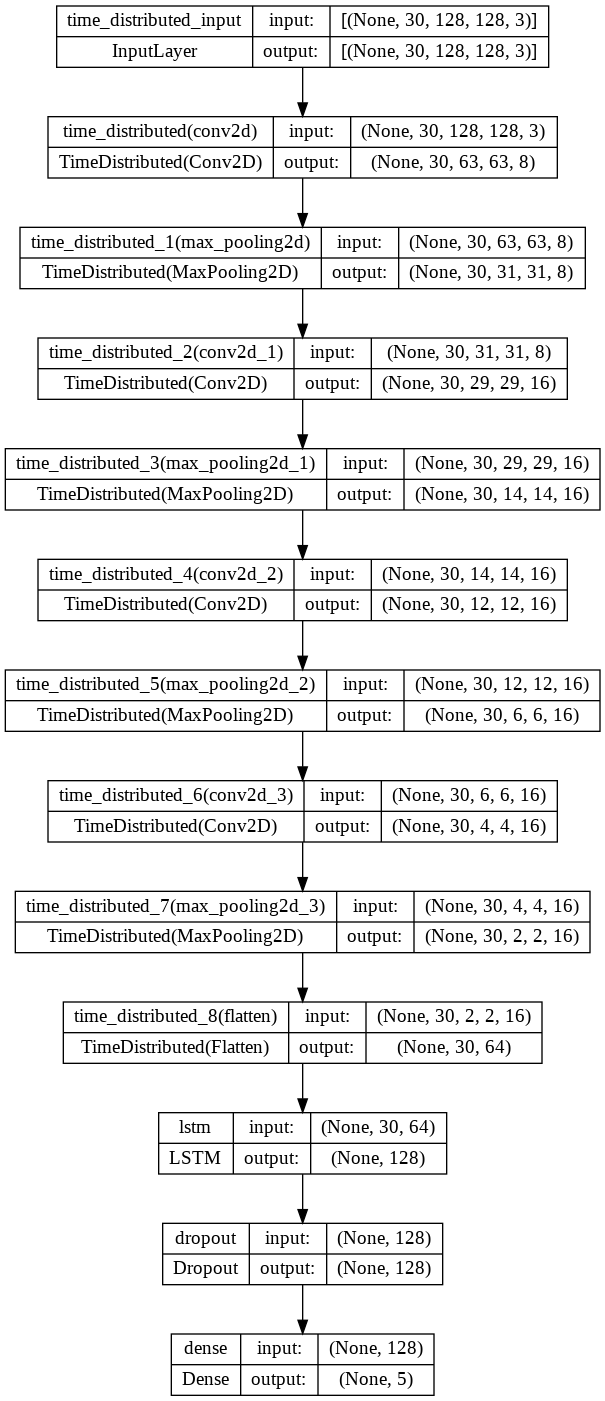

In [12]:
# Plot a diagram of the model
tf.keras.utils.plot_model(model_cnnLSTM_v1, "cnnLSTM_01.png", show_shapes=True)

In [13]:
model_cnnLSTM_v1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.5317 - categorical_accuracy: 0.2805 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1

Epoch 1: val_loss improved from inf to 1.43591, saving model to output/CNN3D/cnn_lstm_01_2022-11-1607_21_01.610201/model-00001-1.53171-0.28054-1.43591-0.41000.h5
42/42 [==============================] - 118s 3s/step - loss: 1.5317 - categorical_accuracy: 0.2805 - val_loss: 1.4359 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3817 - categorical_accuracy: 0.4268
Epoch 2: val_loss improved from 1.43591 to 1.32432, saving model to output/CNN3D/cnn_lstm_01_2022-11-1607_21_01.610201/model-00002-1.38165-0.42685-1.32432-0.41000.h5
42/42 [==============================] - 109s 3s/step - loss: 1.3817 - categorical_accu

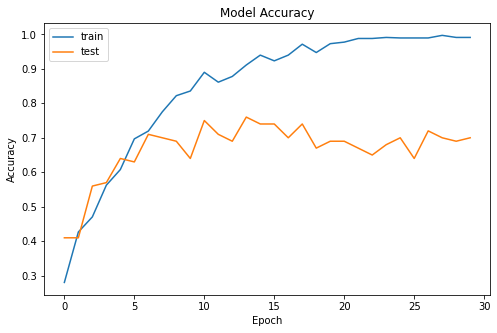

In [14]:
# Plot the model accuracy
plot_accuracy(model_cnnLSTM_v1.history)

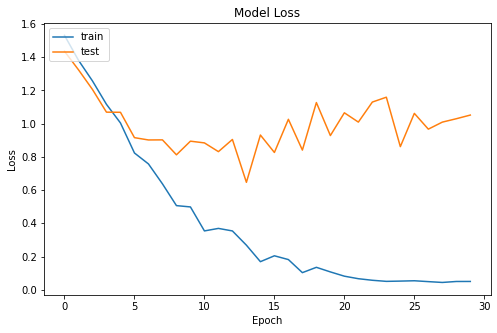

In [15]:
# Plot the model loss
plot_loss(model_cnnLSTM_v1.history)

## Buidl CNN3D Model version 2

In [16]:
model_cnnLSTM_v2  = GestureNet.cnnLSTM_v2()

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=2)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=2)

filepath = save_model_path(model_cnnLSTM_v2.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adadelta(learning_rate=1,)
model_cnnLSTM_v2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnnLSTM_v2.summary())

# filepath:  output/CNN3D/cnn_lstm_02_2022-11-1607_21_01.610201/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn_lstm_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 62, 62, 8)    608       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 31, 31, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 27, 27, 32)   6432      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 13, 1

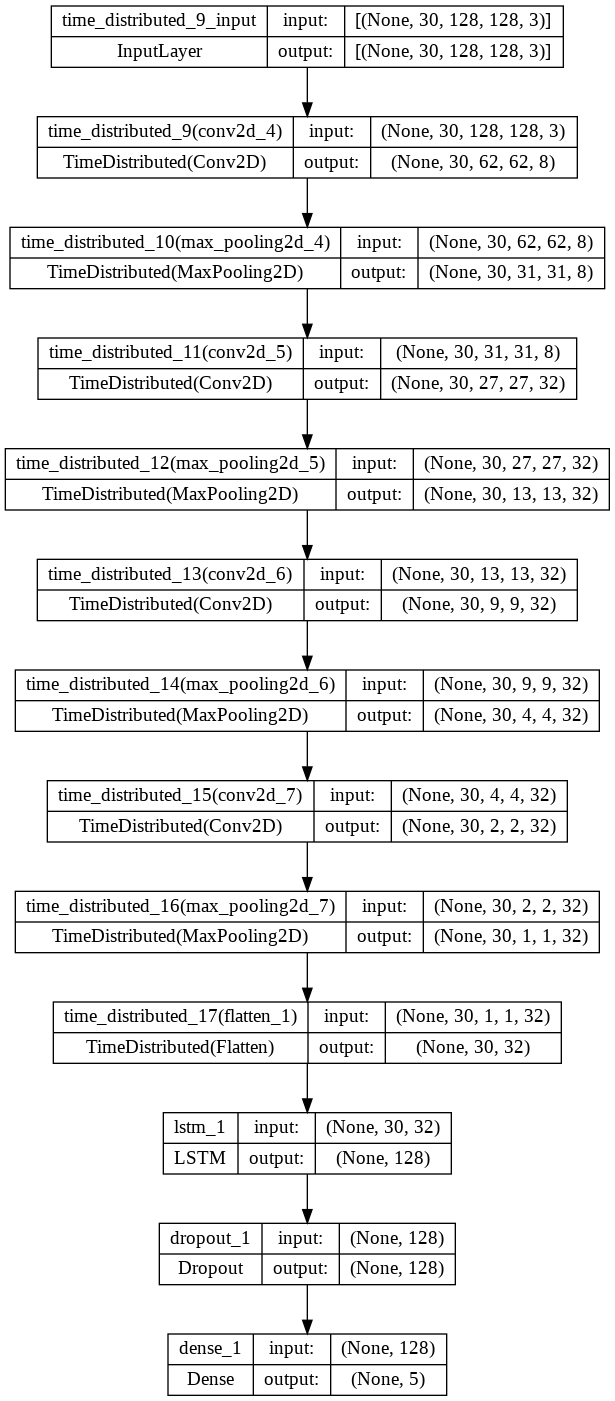

In [17]:
# Plot a diagram of the model
tf.keras.utils.plot_model(model_cnnLSTM_v2, "cnnLSTM_02.png", show_shapes=True)

In [18]:
model_cnnLSTM_v2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 2
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.8214 - categorical_accuracy: 0.1976 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 2

Epoch 1: val_loss improved from inf to 1.67823, saving model to output/CNN3D/cnn_lstm_02_2022-11-1607_21_01.610201/model-00001-1.82142-0.19759-1.67823-0.16000.h5
42/42 [==============================] - 154s 4s/step - loss: 1.8214 - categorical_accuracy: 0.1976 - val_loss: 1.6782 - val_categorical_accuracy: 0.1600 - lr: 1.0000
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.7191 - categorical_accuracy: 0.2127
Epoch 2: val_loss improved from 1.67823 to 1.62882, saving model to output/CNN3D/cnn_lstm_02_2022-11-1607_21_01.610201/model-00002-1.71913-0.21267-1.62882-0.18000.h5
42/42 [==============================] - 152s 4s/step - loss: 1.7191 - categorical_accu

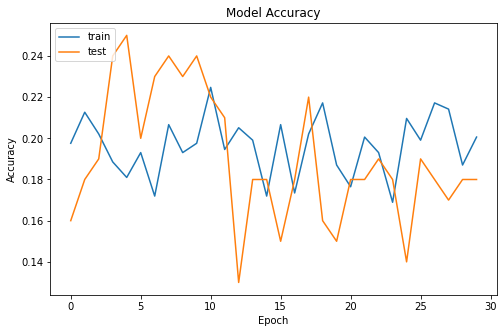

In [19]:
# Plot the model accuracy
plot_accuracy(model_cnnLSTM_v2.history)

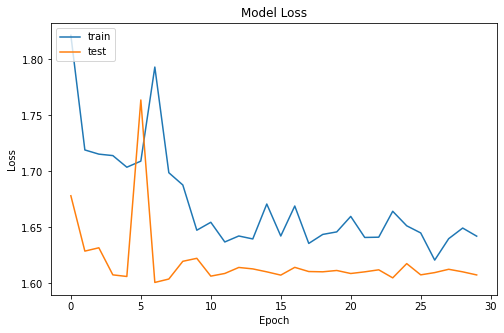

In [20]:
# Plot the model loss
plot_loss(model_cnnLSTM_v2.history)

## Buidl CNN3D Model version 3

In [21]:
model_cnnLSTM_v3  = GestureNet.cnnLSTM_v3()

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=0)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=0)

filepath = save_model_path(model_cnnLSTM_v3.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adadelta(learning_rate=1e-2,)
model_cnnLSTM_v3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnnLSTM_v3.summary())

# filepath:  output/CNN3D/cnn_lstm_03_2022-11-1607_21_01.610201/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn_lstm_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 30, 62, 62, 8)    608       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 31, 31, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 27, 27, 32)   6432      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 13, 1

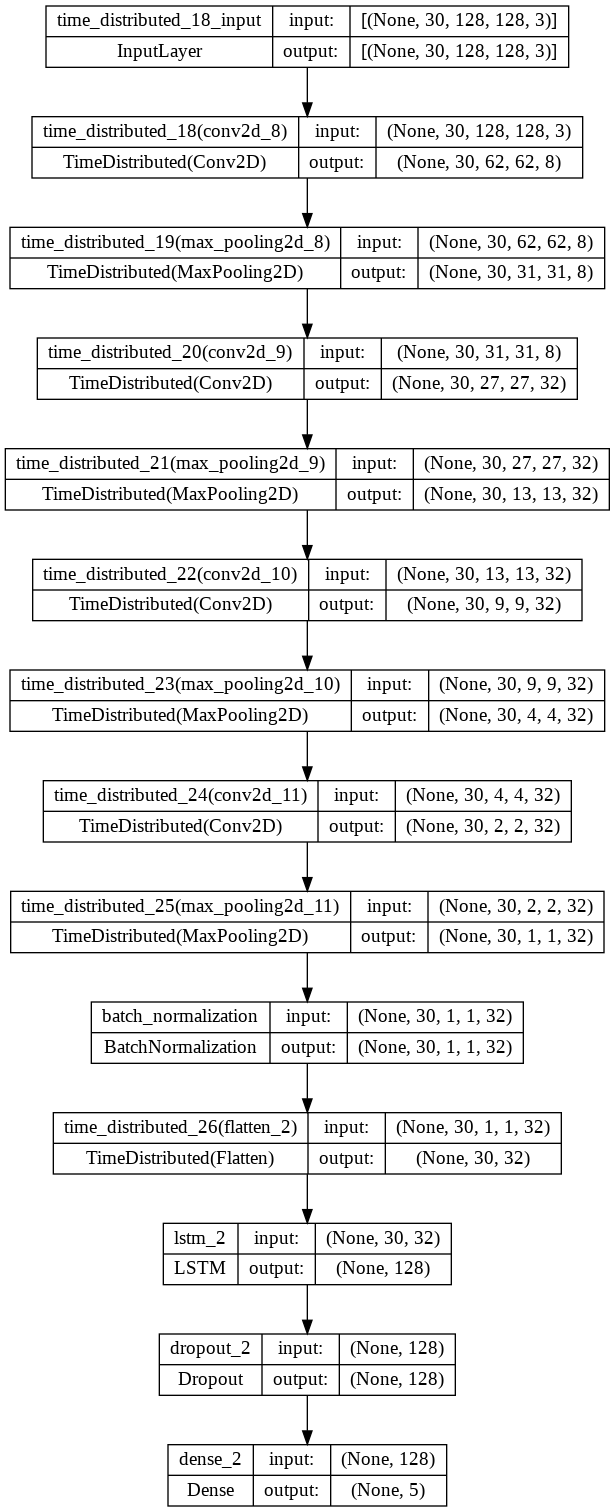

In [22]:
# Plot a diagram of the model
tf.keras.utils.plot_model(model_cnnLSTM_v3, "cnnLSTM_03.png", show_shapes=True)

In [23]:
model_cnnLSTM_v3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 0
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.6242 - categorical_accuracy: 0.2202 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 0

Epoch 1: val_loss improved from inf to 1.60132, saving model to output/CNN3D/cnn_lstm_03_2022-11-1607_21_01.610201/model-00001-1.62418-0.22021-1.60132-0.23000.h5
42/42 [==============================] - 109s 3s/step - loss: 1.6242 - categorical_accuracy: 0.2202 - val_loss: 1.6013 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.5619 - categorical_accuracy: 0.2655
Epoch 2: val_loss improved from 1.60132 to 1.59027, saving model to output/CNN3D/cnn_lstm_03_2022-11-1607_21_01.610201/model-00002-1.56194-0.26546-1.59027-0.24000.h5
42/42 [==============================] - 107s 3s/step - loss: 1.5619 - categorical_accu

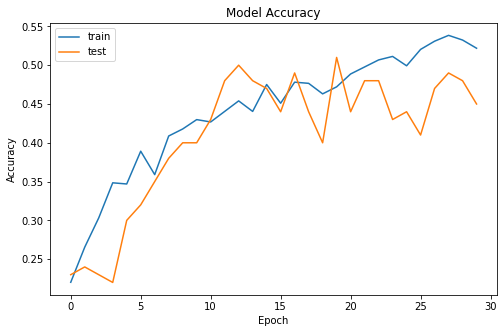

In [24]:
# Plot the model accuracy
plot_accuracy(model_cnnLSTM_v3.history)

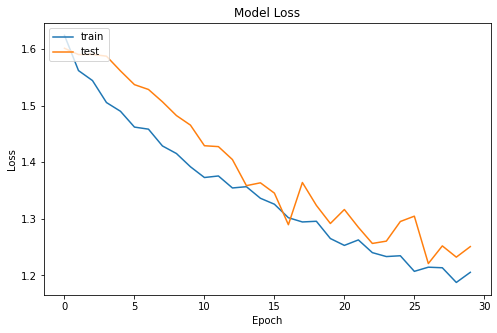

In [25]:
# Plot the model loss
plot_loss(model_cnnLSTM_v3.history)